<a href="https://colab.research.google.com/github/polymoe/datascientest/blob/main/1_Assurance_prediction_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/logo_datascientest.png" style="height:150px;center"></center>

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning - Modules complémentaires</h1></center>
<center><h2>Régression sur des données structurées</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


Le but de cet exercice est de s'entraîner à faire une régression sur des données structurées à l'aide d'un réseau de neurones dense.

 Nous allons travailler avec la base de données **```insurance.csv```**, qui contient les informations personnelles de clients d'une assurance, ainsi que les charges qu'ils ont à payer.

> La structure de l'exercice est la suivante : 
>> I - [Préparation du dataset](#preparation)
>>
>>
>> II - [Régression linéaire multiple classique](#linear)
>>
>>
>> III - [Régression à l'aide d'un réseau de neurones dense](#dnn)
>>
>>
>> IV - [Comparaison des résultats obtenus avec les deux techniques](#comparaison)

- Exécuter les cellules ci-dessous pour importer le dataset et les modules nécessaires à l'exercice.

In [ ]:
!wget https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/insurance.zip
!unzip insurance.zip

--2021-05-05 14:53:45--  https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/insurance.zip
Resolving assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)... 52.218.60.128
Connecting to assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)|52.218.60.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16429 (16K) [application/zip]
Saving to: ‘insurance.zip’

insurance.zip       100%[===================>]  16.04K  --.-KB/s    in 0s      

2021-05-05 14:53:46 (54.6 MB/s) - ‘insurance.zip’ saved [16429/16429]

Archive:  insurance.zip
  inflating: insurance.csv           


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import r2_score

# <a name="preparation"></a> I - Préparation du dataset

- (a) Charger le jeu de données **```insurance.csv```** dans un DataFrame ```df```.

- (b) Afficher la shape de ```df``` ainsi que ses 5 premières lignes.

In [ ]:
df = pd.read_csv('insurance.csv')

In [ ]:
print("Nombre de lignes dans le dataset : {}".format(df.shape[0]))
print("Nombre de colonnes dans le dataset : {}".format(df.shape[1]))

df.head()

Nombre de lignes dans le dataset : 1338
Nombre de colonnes dans le dataset : 7


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


- (c) Vérifier que les colonnes de ```df``` sont du bon type, et traiter les valeurs manquantes s'il y en a.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df['children'] = df['children'].astype(str)

In [ ]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- (d) Créer une visualisation pertinente pour chaque colonne de ```df```.

- (e) Supprimer les colonnes qui ne vous semblent pas impacter les charges à payer.

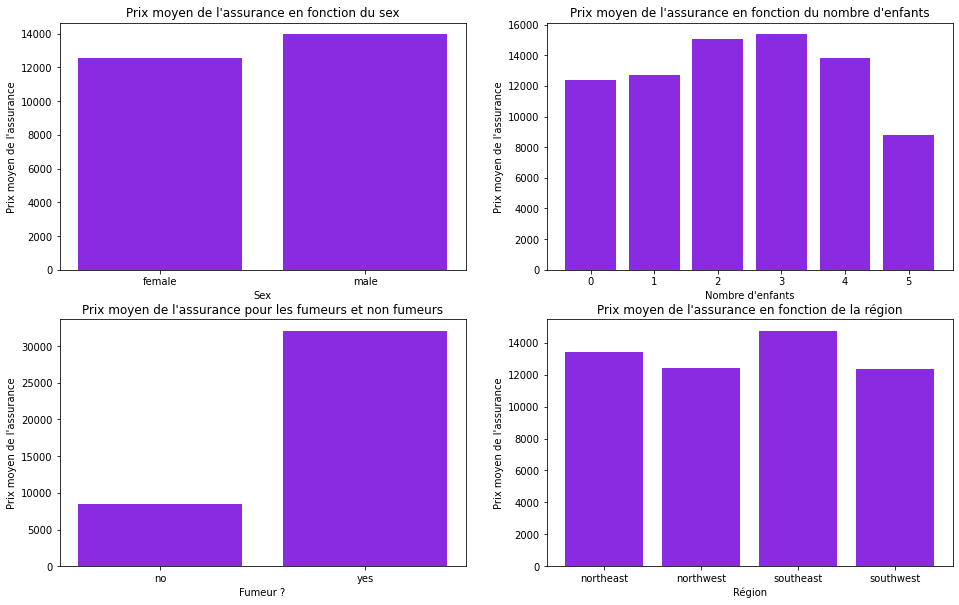

In [ ]:
charges_sex = df.groupby('sex').mean()['charges']
charges_children = df.groupby('children').mean()['charges']
charges_smoke = df.groupby('smoker').mean()['charges']
charges_region = df.groupby('region').mean()['charges']

plt.figure(figsize=(16, 10))

plt.subplot(221)
plt.bar(charges_sex.index, charges_sex.values, color='blueviolet')
plt.title("Prix moyen de l'assurance en fonction du sex")
plt.xlabel("Sex")
plt.ylabel("Prix moyen de l'assurance")

plt.subplot(222)
plt.bar(charges_children.index, charges_children.values, color='blueviolet')
plt.title("Prix moyen de l'assurance en fonction du nombre d'enfants")
plt.xlabel("Nombre d'enfants")
plt.ylabel("Prix moyen de l'assurance")

plt.subplot(223)
plt.bar(charges_smoke.index, charges_smoke.values, color='blueviolet')
plt.title("Prix moyen de l'assurance pour les fumeurs et non fumeurs")
plt.xlabel("Fumeur ?")
plt.ylabel("Prix moyen de l'assurance")

plt.subplot(224)
plt.bar(charges_region.index, charges_region.values, color='blueviolet')
plt.title("Prix moyen de l'assurance en fonction de la région")
plt.xlabel("Région")
plt.ylabel("Prix moyen de l'assurance");

In [ ]:
# Variation très faible pour la région, on peut supprimer cette colonne
df = df.drop(labels='region', axis=1)

In [ ]:
def lissage(x,y,p):
    x_lisse=[]
    y_lisse=[]
    for i in range(p,len(x)-p):  
        x_lisse.append(x[i])
    for i in range(p,len(y)-p):
        val=0
        for k in range(2*p):
            val+=y[i-p+k]
        y_lisse.append(val/2/p)
    return x_lisse, y_lisse

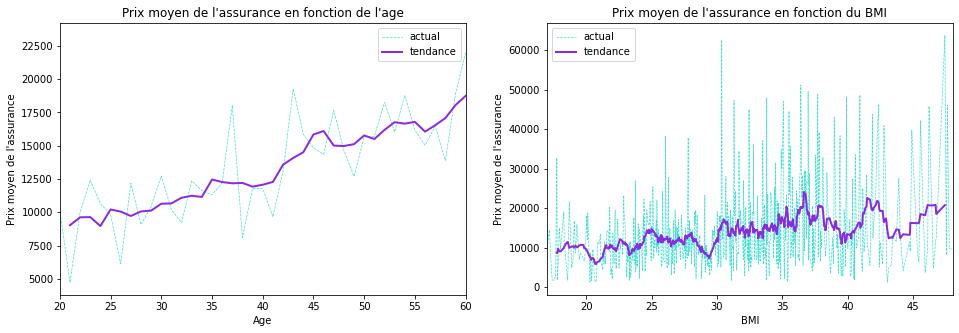

In [ ]:
charges_age = df.groupby('age').mean()['charges']
charges_bmi = df.groupby('bmi').mean()['charges']

plt.figure(figsize=(16, 5))

plt.subplot(121)
x = charges_age.index
y = charges_age.values
x_lisse, y_lisse = lissage(x, y, 3)
plt.plot(x, y, color='turquoise', linewidth=0.7, linestyle='dashed', label='actual')
plt.plot(x_lisse, y_lisse, color='blueviolet', linewidth=2, label='tendance')
plt.xlim(20, 60)
plt.xlabel('Age')
plt.ylabel("Prix moyen de l'assurance")
plt.title("Prix moyen de l'assurance en fonction de l'age")
plt.legend()

plt.subplot(122)
x = charges_bmi.index
y = charges_bmi.values
x_lisse, y_lisse = lissage(x, y, 8)
plt.plot(x, y, color='turquoise', linewidth=0.7, linestyle='dashed', label='actual')
plt.plot(x_lisse, y_lisse, color='blueviolet', linewidth=2, label='tendance')
plt.xlim(17, 48)
plt.xlabel('BMI')
plt.ylabel("Prix moyen de l'assurance")
plt.title("Prix moyen de l'assurance en fonction du BMI")
plt.legend();

- (f) Finir de préparer les données.
> Cette partie regroupe :
>> - L'encodage des variables
>>
>>
>> - la séparation des variables explicatives de la variable cible
>>
>>
>> - La création d'un jeu de test et d'entraînement
>>
>>
>> - Le scaling de ```X_train```, ```X_test``` **et de ```y_train```, ```y_test```**


In [ ]:
df['sex'] = df['sex'].replace({'female' : 0, 'male' : 1})
df['smoker'] = df['smoker'].replace({'no' : 0, 'yes' : 1})
df = pd.get_dummies(df)

In [ ]:
df.head()

,age,sex,bmi,smoker,charges,children_0,children_1,children_2,children_3,children_4,children_5
0,19,0,27.900,1,16884.92400,1,0,0,0,0,0
1,18,1,33.770,0,1725.55230,0,1,0,0,0,0
2,28,1,33.000,0,4449.46200,0,0,0,1,0,0
3,33,1,22.705,0,21984.47061,1,0,0,0,0,0
4,32,1,28.880,0,3866.85520,1,0,0,0,0,0


In [ ]:
X = df.drop(labels='charges', axis=1)
y = df['charges'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
scaler_X = MinMaxScaler()

scaler_X.fit(X_train)
X_train_scaled = pd.DataFrame(scaler_X.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
scaler_y = MinMaxScaler()

y_train=np.reshape(y_train, (-1,1))
y_test=np.reshape(y_test, (-1,1))

scaler_y.fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# II - <a name="linear"></a> Régression linéaire multiple classique

- (a) Instancier un modèle de régression linéaire.

- (b) Fit le modèle aux données d'entraînement.

- (c) Effectuer une prédiction à partir des données de test (attention au scaling).

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_lr = scaler_y.inverse_transform(lr.predict(X_test_scaled)) 

# III - <a name="dnn"></a> Régression à l'aide d'un réseau de neurones dense

- (a) Instancier un réseau de neurones dense de l'architecture de votre choix (attention à la couche de sortie, il s'agit d'un problème de régression).

- (b) Compiler le modèle avec une métrique appropriée.

- (c) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (d) Effectuer une prédiction à partir des données de test (attention au scaling).

In [ ]:
input_shape = (X_train_scaled.shape[1],)

In [ ]:
model = Sequential()
model.add(Dense(units=10, input_shape=input_shape, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 20,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=5,
                            factor=0.8,
                            verbose=2,
                            mode='min')

In [ ]:
model.compile(loss='mae', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train_scaled, y_train_scaled, epochs = 200, batch_size = 30, validation_split = 0.2, callbacks = [early_stopping,lr_plateau]) 

Epoch 1/200
29/29 [==============================] - 2s 32ms/step - loss: 0.1593 - mse: 0.0522 - mae: 0.1593 - val_loss: 0.1002 - val_mse: 0.0263 - val_mae: 0.1002
Epoch 2/200
29/29 [==============================] - 0s 13ms/step - loss: 0.0824 - mse: 0.0194 - mae: 0.0824 - val_loss: 0.0765 - val_mse: 0.0154 - val_mae: 0.0765
Epoch 3/200
29/29 [==============================] - 0s 13ms/step - loss: 0.0690 - mse: 0.0146 - mae: 0.0690 - val_loss: 0.0654 - val_mse: 0.0134 - val_mae: 0.0654
Epoch 4/200
29/29 [==============================] - 0s 13ms/step - loss: 0.0650 - mse: 0.0130 - mae: 0.0650 - val_loss: 0.0599 - val_mse: 0.0127 - val_mae: 0.0599
Epoch 5/200
29/29 [==============================] - 0s 13ms/step - loss: 0.0610 - mse: 0.0124 - mae: 0.0610 - val_loss: 0.0581 - val_mse: 0.0118 - val_mae: 0.0581
Epoch 6/200
29/29 [==============================] - 0s 14ms/step - loss: 0.0640 - mse: 0.0122 - mae: 0.0640 - val_loss: 0.0561 - val_mse: 0.0105 - val_mae: 0.0561
Epoch 7/200
29/2

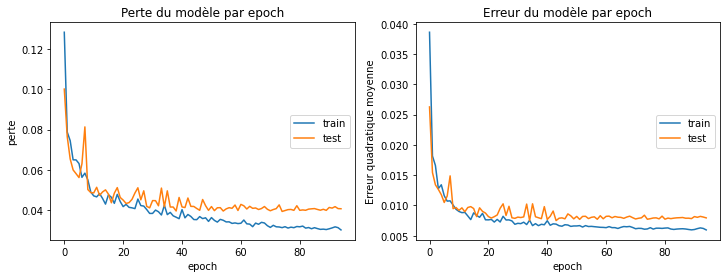

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle par epoch')
plt.ylabel('perte')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Erreur du modèle par epoch')
plt.ylabel('Erreur quadratique moyenne')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
y_pred_dnn = scaler_y.inverse_transform(model.predict(X_test_scaled))

# IV - <a name="comparaison"></a> Comparaison des résultats obtenus avec les deux techniques

- (a) Comparer les résultats obtenus avec les deux modèles (utiliser le ```r2_score``` par exemple).

In [ ]:
result = pd.DataFrame()
result['y_test'] = [y_test[i][0] for i in range(len(y_test))]
result['y_pred_lr'] = [y_pred_lr[i][0] for i in range(len(y_pred_lr))]
result['y_pred_dnn'] = [y_pred_dnn[i][0] for i in range(len(y_pred_dnn))]
result.head(10)

,y_test,y_pred_lr,y_pred_dnn
0,9800.88820,16017.830362,10050.867188
1,4667.60765,9018.133067,4450.803711
2,34838.87300,28488.850833,28641.277344
3,5125.21570,5468.261480,4895.868164
4,12142.57860,11538.509563,12267.756836
5,10702.64240,10667.203309,11019.179688
6,4827.90495,1655.588452,5010.414062
7,4766.02200,3191.485491,5425.725098
8,1674.63230,4409.223795,2005.378296
9,9361.32680,8141.631455,9173.564453


In [ ]:
print("r2_score du modèle lr : {}".format(r2_score(y_test, y_pred_lr)))
print("r2_score du modèle dnn : {}".format(r2_score(y_test, y_pred_dnn)))

r2_score du modèle lr : 0.7963958782947849
r2_score du modèle dnn : 0.8692014876399028
